In [1]:
import os

import numpy as np
import re
import keras 
import tensorflow_hub as hub
import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker import configs
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader
from tflite_model_maker import ImageClassifierDataLoader


import matplotlib.pyplot as plt



In [2]:
#Plot modules
import pandas as pd

#keras
from tensorflow.keras import layers

#Confusion Matrix
# from sklearm.metrics import confusion_matrix


In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
#Loading the dataset

base_dir = './dataset/train'
os.environ["TFHUB_CACHE_DIR"] = "some_dir"
data = DataLoader.from_folder(base_dir, shuffle= True)

INFO:tensorflow:Load image with size: 464, num_label: 2, labels: Bruise, Cuts.


In [5]:
#Dataset Splitting

train_data, rest_data = data.split(0.80)
validation_data, test_data = rest_data.split(0.5)

In [6]:
#Splittng result

total_size = (train_data._size + validation_data._size + test_data._size)
print('Records in Training Data: {} ({:.2%}), Validation Data: {} ({:.2%}) and Test Data: {} ({:.2%})'\
      .format(train_data._size, train_data._size/total_size, validation_data._size, 
      validation_data._size/total_size, test_data._size, test_data._size/total_size))


Records in Training Data: 371 (79.96%), Validation Data: 46 (9.91%) and Test Data: 47 (10.13%)


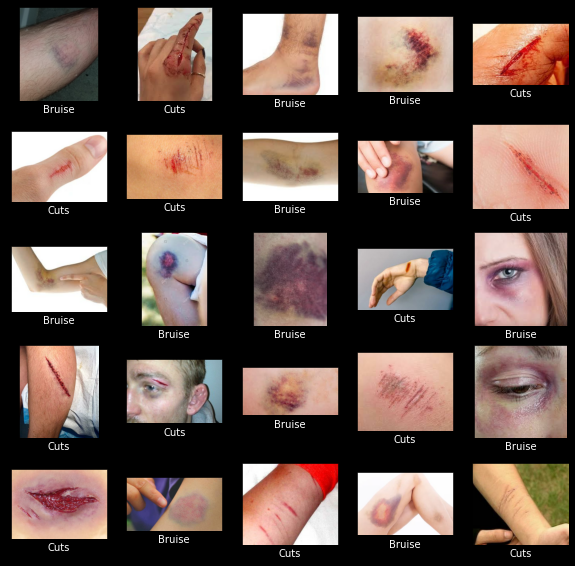

In [7]:
#Data visualization with their corresponding label

def get_label_color(colors):
  return 'White'

fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('black')
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  ax = plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
  color = get_label_color(data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
plt.show()

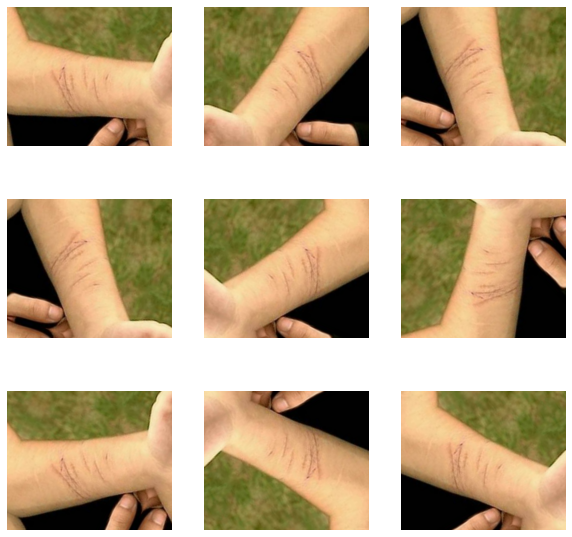

In [8]:
#Data augmentation
#Flip and Rotate

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

image = tf.expand_dims(image, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [42]:
#Training the CNN model and hyperparameter tuning
#Transfer Learning using Efficientnet Lite Version 2

model = image_classifier.create(
    train_data, 
    dropout_rate= 0.2, 
    use_augmentation= True, 
    train_whole_model=False, 
    epochs= 200,  
    batch_size= 16,
    learning_rate = 0.0004,
    do_train = True, 
    shuffle = True,
    model_spec= model_spec.get('efficientnet_lite2'), 
    validation_data = validation_data)


INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_5 (HubK (None, 1280)              4869168   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2562      
Total params: 4,871,730
Trainable params: 2,562
Non-trainable params: 4,869,168
_________________________________________________________________
None
INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


Epoch 1/200
23/23 [==============================] - 11s 425ms/step - loss: 0.6456 - accuracy: 0.6576 - val_loss: 0.6016 - val_accuracy: 0.7812
Epoch 2/200
23/23 [==============================] - 9s 401ms/step - loss: 0.5904 - accuracy: 0.7147 - val_loss: 0.5296 - val_accuracy: 0.8125
Epoch 3/200
23/23 [==============================] - 9s 403ms/step - loss: 0.5434 - accuracy: 0.7663 - val_loss: 0.4875 - val_accuracy: 0.9062
Epoch 4/200
23/23 [==============================] - 9s 407ms/step - loss: 0.5322 - accuracy: 0.7500 - val_loss: 0.4533 - val_accuracy: 0.9062
Epoch 5/200
23/23 [==============================] - 9s 407ms/step - loss: 0.5157 - accuracy: 0.7908 - val_loss: 0.4273 - val_accuracy: 0.9062
Epoch 6/200
23/23 [==============================] - 9s 404ms/step - loss: 0.4752 - accuracy: 0.8043 - val_loss: 0.4060 - val_accuracy: 0.9375
Epoch 7/200
23/23 [==============================] - 9s 410ms/step - loss: 0.4722 - accuracy: 0.8179 - val_loss: 0.3909 - val_accuracy: 0.906

In [43]:
model.summary() 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_5 (HubK (None, 1280)              4869168   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2562      
Total params: 4,871,730
Trainable params: 2,562
Non-trainable params: 4,869,168
_________________________________________________________________


In [73]:
history = model.model.history.history

<function matplotlib.pyplot.show(close=None, block=None)>

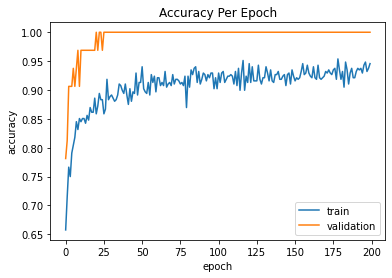

In [75]:
#Train accuracy and Validation accuracy

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Accuracy Per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower right')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

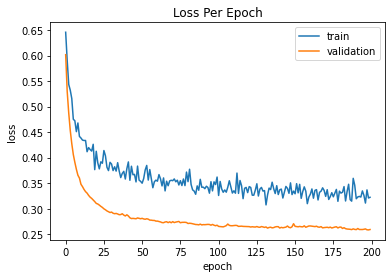

In [77]:
#Train loss and Validation loss

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

In [70]:
#Evaluation of train, validation, and test dataset

print("\nTest\n")
loss, accuracy = model.evaluate(test_data)
print("\nValidaiton\n")
loss, accuracy = model.evaluate(validation_data)
print("\nTrain\n")
loss, accuracy = model.evaluate(train_data)


Test

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


2/2 [==============================] - 2s 365ms/step - loss: 0.3120 - accuracy: 0.9787

Validaiton

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


2/2 [==============================] - 2s 343ms/step - loss: 0.3268 - accuracy: 0.9783

Train

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


12/12 [==============================] - 9s 696ms/step - loss: 0.2728 - accuracy: 0.9730


In [65]:
probability_model = model

In [67]:
#Predicting the first image in test dataset

predictions = probability_model.predict_top_k(test_data, k=2)
pred = predictions[0]


print(", ".join(map(str, pred)))

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


('Cuts', 0.7664398), ('Bruise', 0.23356019)


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


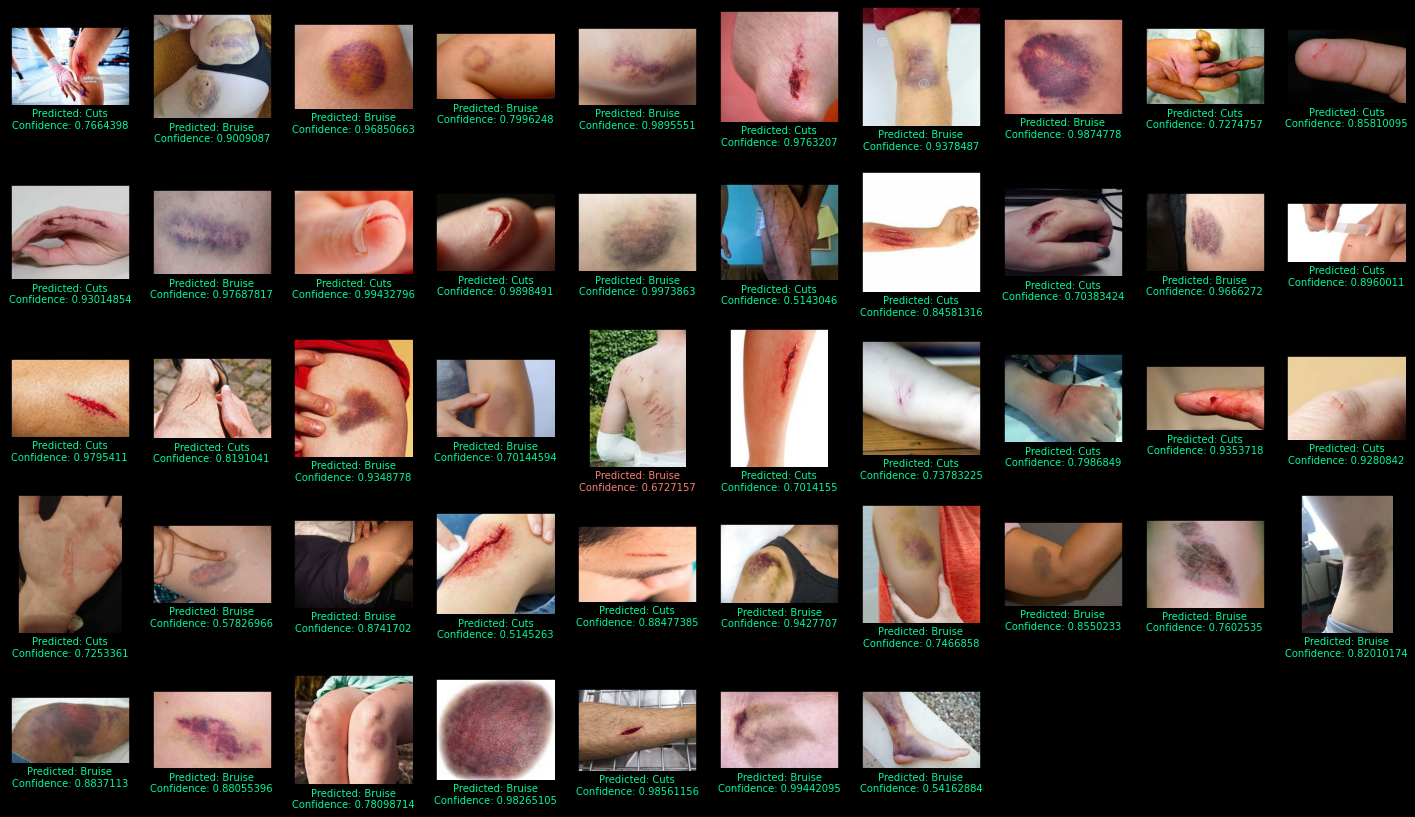

In [64]:
#Predicting the test dataset
#Data Visualization

def get_label_color(val1, val2):
  if val1 == val2:
    return 'MediumSpringGreen'
  else:
    return 'Salmon'

fig = plt.figure(figsize=(25, 30))
fig.patch.set_facecolor('black')
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0]
  color = get_label_color(predict_label[0],
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel("Predicted: "+"\nConfidence: ".join(map(str, predict_label)))
plt.show()

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


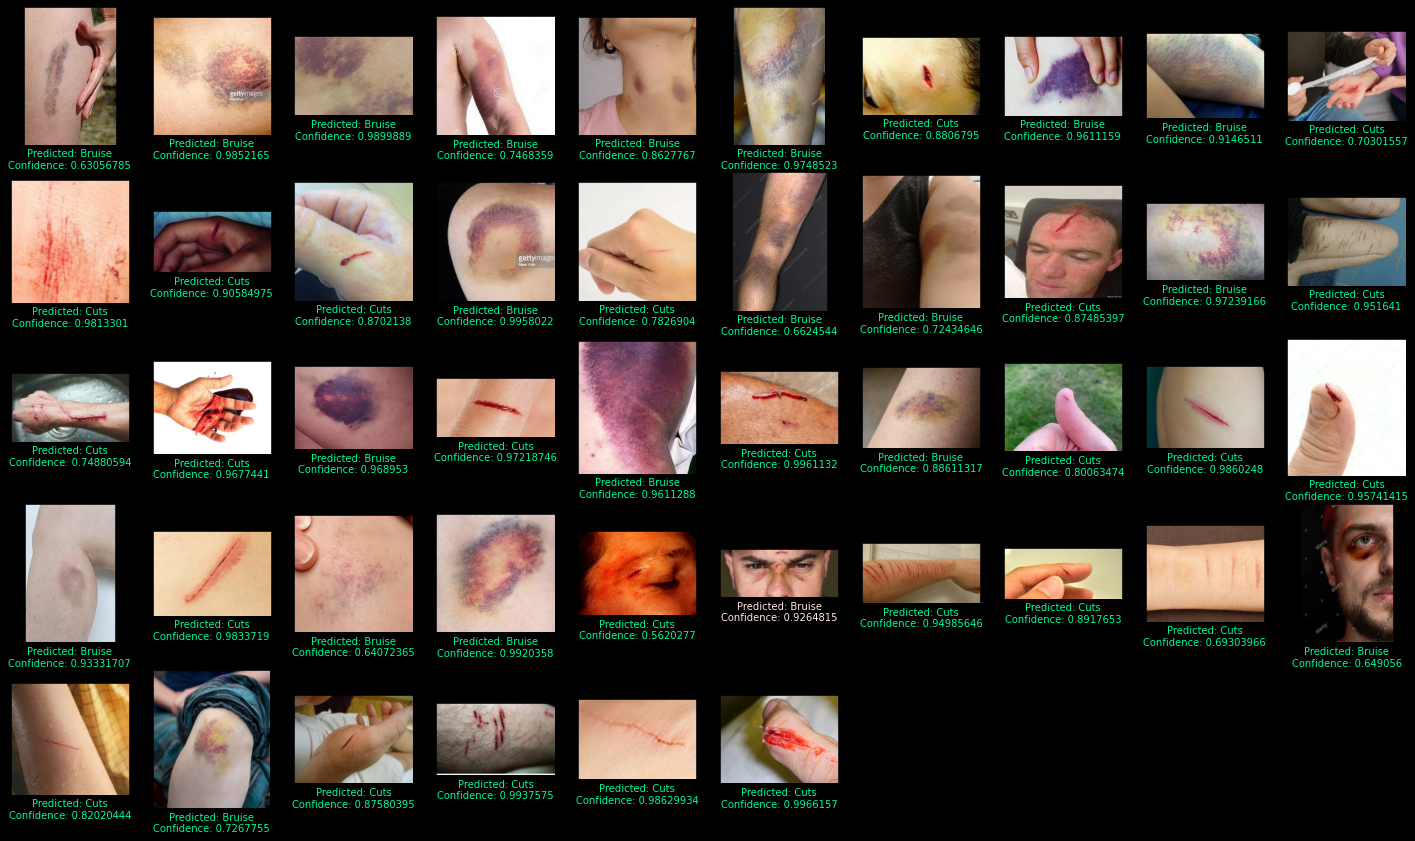

In [63]:
#Predicting the validation dataset
#Data Visualization

def get_label_color(val1, val2):
  if val1 == val2:
    return 'MediumSpringGreen'
  else:
    return 'MistyRose'

fig = plt.figure(figsize=(25, 30))
fig.patch.set_facecolor('black')
predicts = model.predict_top_k(validation_data)
for i, (image, label) in enumerate(validation_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0]
  color = get_label_color(predict_label[0],
                          validation_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel("Predicted: "+"\nConfidence: ".join(map(str, predict_label)))
plt.show()

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


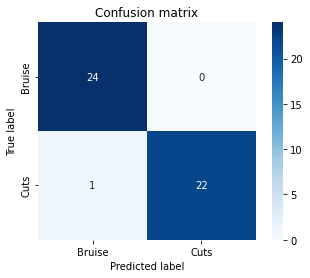

In [55]:
#Confusion Matrix
#Accuracy: 0.9787
#Precision: 0.96
#Recall: 1
#True Negative Rate: 0.9565


def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype('int') 
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [57]:
#Quantizing the model

config = QuantizationConfig.for_float16()

In [58]:
#Exporting the raw model

model.export(export_dir='.', tflite_filename='model_uint8.tflite',)
model.export(export_dir='.', export_format=ExportFormat.LABEL)

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Assets written to: C:\Users\Jumple\AppData\Local\Temp\tmpplg1qpfh\assets


INFO:tensorflow:Assets written to: C:\Users\Jumple\AppData\Local\Temp\tmpplg1qpfh\assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in C:\Users\Jumple\AppData\Local\Temp\tmp5qg0701e\labels.txt


INFO:tensorflow:Saving labels in C:\Users\Jumple\AppData\Local\Temp\tmp5qg0701e\labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: .\model_uint8.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: .\model_uint8.tflite


INFO:tensorflow:Saving labels in .\labels.txt


INFO:tensorflow:Saving labels in .\labels.txt


In [59]:
#Exporting the quantized model

model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)
model.export(export_dir='.', export_format=ExportFormat.LABEL)

INFO:tensorflow:Assets written to: C:\Users\Jumple\AppData\Local\Temp\tmpiyzdz1nv\assets


INFO:tensorflow:Assets written to: C:\Users\Jumple\AppData\Local\Temp\tmpiyzdz1nv\assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in C:\Users\Jumple\AppData\Local\Temp\tmp7qs77l1t\labels.txt


INFO:tensorflow:Saving labels in C:\Users\Jumple\AppData\Local\Temp\tmp7qs77l1t\labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: .\model_fp16.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: .\model_fp16.tflite


INFO:tensorflow:Saving labels in .\labels.txt


INFO:tensorflow:Saving labels in .\labels.txt


In [60]:
#Evaluation of the quantiized model using test dataset

model.evaluate_tflite('model_fp16.tflite', test_data)

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


{'accuracy': 0.9787234042553191}

In [61]:
#Evaluation of the quantiized model using test dataset

model.evaluate_tflite('model_fp16.tflite', validation_data)

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


{'accuracy': 0.9782608695652174}

In [62]:
#Evaluation of the quantiized model using test dataset

model.evaluate_tflite('model_fp16.tflite', train_data)

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


{'accuracy': 0.9730458221024259}